In [1]:
!wget http://ipa.lovethosetrains.com/ipa_17_18.7z

--2020-02-14 20:43:27--  http://ipa.lovethosetrains.com/ipa_17_18.7z
Resolving ipa.lovethosetrains.com... 51.255.167.155
Connecting to ipa.lovethosetrains.com|51.255.167.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152896489 (146M) [application/x-7z-compressed]
Saving to: 'ipa_17_18.7z.1'

ipa_17_18.7z.1      100%[===================>] 145.81M  3.29MB/s    in 63s     

2020-02-14 20:44:30 (2.33 MB/s) - 'ipa_17_18.7z.1' saved [152896489/152896489]



In [6]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .master("local") \
    .appName("Test it 2") \
    .getOrCreate()
sc = spark.sparkContext

In [16]:
from pyspark.sql import types

In [20]:
types.StructType?

In [28]:
from pyspark.sql import types
from pyspark.sql.types import StructType, LongType, StructField, TimestampType

In [29]:
StructField?

In [34]:
from pyspark.sql import types
from pyspark.sql.types import StructType, LongType, StructField, TimestampType, StringType

# root
#  |-- train_id: long (nullable = true)
#  |-- train_name: string (nullable = true)
#  |-- schedule_date: timestamp (nullable = true)
#  |-- schedule_id: long (nullable = true)
#  |-- arrival_delay: long (nullable = true)
#  |-- arrival_time: timestamp (nullable = true)
#  |-- departure_delay: long (nullable = true)
#  |-- departure_time: timestamp (nullable = true)
#  |-- station_name: string (nullable = true)

schema = StructType([
        StructField('train_id', LongType()),
        StructField('train_name', StringType()),
        StructField('schedule_date', TimestampType()),
        StructField('schedule_id', LongType()),
        StructField('arrival_delay', LongType()),
        StructField('arrival_time', TimestampType()),
        StructField('departure_delay', LongType()),
        StructField('departure_time', TimestampType()),
        StructField('station_name', StringType())
])
    
trains = spark.read.format("csv")\
        .schema(schema)\
        .option("inferSchema", "true")\
        .load("trains_sample.csv")

In [35]:
trains.printSchema()

root
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)
 |-- schedule_date: timestamp (nullable = true)
 |-- schedule_id: long (nullable = true)
 |-- arrival_delay: long (nullable = true)
 |-- arrival_time: timestamp (nullable = true)
 |-- departure_delay: long (nullable = true)
 |-- departure_time: timestamp (nullable = true)
 |-- station_name: string (nullable = true)



In [36]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)


In [38]:
trains.registerTempTable("trains")

In [39]:
sqlContext.sql("""
    Select * from trains LIMIT 5
""").show()

+--------+------------------+-------------------+-----------+-------------+-------------------+---------------+-------------------+--------------------+
|train_id|        train_name|      schedule_date|schedule_id|arrival_delay|       arrival_time|departure_delay|     departure_time|        station_name|
+--------+------------------+-------------------+-----------+-------------+-------------------+---------------+-------------------+--------------------+
|     159|67900/1 KAMIEŃCZYK|2018-12-08 00:00:00|   53466607|         null|               null|              0|2018-12-08 13:17:00|Szklarska Poręba ...|
|     159|67900/1 KAMIEŃCZYK|2018-12-08 00:00:00|   53466607|            0|2018-12-08 13:21:00|              0|2018-12-08 13:21:30|Szklarska Poręba ...|
|     159|67900/1 KAMIEŃCZYK|2018-12-08 00:00:00|   53466607|            0|2018-12-08 13:27:00|              0|2018-12-08 13:27:30|Szklarska Poręba ...|
|     159|67900/1 KAMIEŃCZYK|2018-12-08 00:00:00|   53466607|            0|2018-12

## Czy w weekendy pociągi sppózniaja sie bardziej?

In [40]:
from pyspark.sql.functions import *

In [58]:
DELAY_BY_DAY = trains\
    .select(
        month(col('arrival_time')).alias('month'),
        dayofweek(col('arrival_time')).alias('day'),
        col('arrival_delay').alias('avg_delay'),
    )\
    .filter(col('day').isNotNull())\
    .groupBy(col('day'))\
    .avg() \
    .sort(col('day').asc())

In [59]:
DELAY_BY_DAY.show()

+---+------------------+--------+------------------+
|day|        avg(month)|avg(day)|    avg(avg_delay)|
+---+------------------+--------+------------------+
|  1|6.4523201750387456|     1.0|3.5273498039930713|
|  2| 6.325463668130096|     2.0| 4.207060299256339|
|  3|6.3998843879229845|     3.0| 5.229312108141758|
|  4| 6.411576704545454|     4.0|4.8405539772727275|
|  5| 6.451109646231598|     5.0| 5.362030323005933|
|  6| 6.495125071690122|     6.0| 4.239158247672829|
|  7| 6.550279329608938|     7.0| 4.122392923649907|
+---+------------------+--------+------------------+



In [72]:
plt_data = DELAY_BY_DAY.toPandas()
plt_data.index = plt_data['day']
plt_data = plt_data[['day','avg(avg_delay)']]

In [73]:
plt_data.describe()

,day,avg(avg_delay)
count,7.000000,7.000000
mean,4.000000,4.503980
std,2.160247,0.662489
min,1.000000,3.527350
25%,2.500000,4.164727
50%,4.000000,4.239158
75%,5.500000,5.034933
max,7.000000,5.362030


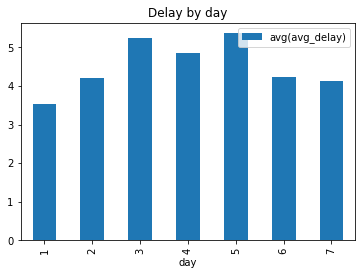

In [75]:
plt_data.plot(kind='bar', x='day', title="Delay by day")

In [79]:
DELAY_BY_MONTH = trains\
    .select(
        year(col('arrival_time')).alias('year'),
        month(col('arrival_time')).alias('month'),
        col('arrival_delay').alias('avg_delay'),
    )\
    .groupBy(col('year'), col('month'))\
    .avg() \
    .dropna() \
    .sort(col('year').asc(), col('month').asc())

In [80]:
DELAY_BY_MONTH.show()

+----+-----+---------+----------+------------------+
|year|month|avg(year)|avg(month)|    avg(avg_delay)|
+----+-----+---------+----------+------------------+
|2017|   12|   2017.0|      12.0| 4.460918443101071|
|2018|    1|   2018.0|       1.0| 6.753192731518646|
|2018|    2|   2018.0|       2.0| 4.799580442149427|
|2018|    3|   2018.0|       3.0| 3.849883517763541|
|2018|    4|   2018.0|       4.0| 3.431587585795285|
|2018|    5|   2018.0|       5.0| 5.665816709164542|
|2018|    6|   2018.0|       6.0| 5.333827893175074|
|2018|    7|   2018.0|       7.0|2.7608613809201112|
|2018|    8|   2018.0|       8.0|  6.28526573747894|
|2018|    9|   2018.0|       9.0| 4.003141183462094|
|2018|   10|   2018.0|      10.0|3.2482092805979446|
|2018|   11|   2018.0|      11.0|3.7751004016064256|
|2018|   12|   2018.0|      12.0| 3.257868899797863|
+----+-----+---------+----------+------------------+



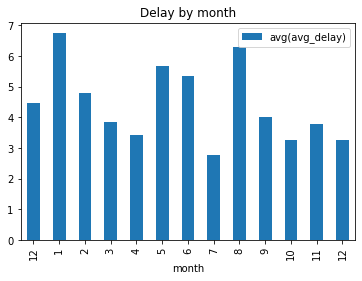

In [83]:
plt_data = DELAY_BY_MONTH.toPandas()
plt_data[['month', 'avg(avg_delay)']].plot(kind='bar', x='month', title="Delay by month")

## Czy jest jakiś czarny punk stacja??

In [85]:
by_stations = sqlContext.sql("""
    Select * from trains LIMIT 2
""").show()

+--------+------------------+-------------------+-----------+-------------+-------------------+---------------+-------------------+--------------------+
|train_id|        train_name|      schedule_date|schedule_id|arrival_delay|       arrival_time|departure_delay|     departure_time|        station_name|
+--------+------------------+-------------------+-----------+-------------+-------------------+---------------+-------------------+--------------------+
|     159|67900/1 KAMIEŃCZYK|2018-12-08 00:00:00|   53466607|         null|               null|              0|2018-12-08 13:17:00|Szklarska Poręba ...|
|     159|67900/1 KAMIEŃCZYK|2018-12-08 00:00:00|   53466607|            0|2018-12-08 13:21:00|              0|2018-12-08 13:21:30|Szklarska Poręba ...|
+--------+------------------+-------------------+-----------+-------------+-------------------+---------------+-------------------+--------------------+



In [91]:
DELAY_BY_STATION = trains\
    .select(
        col('station_name'),
        col('arrival_delay').alias('avg_delay'),
    )\
    .groupBy(col('station_name'))\
    .avg() \
    .dropna() \
    .sort(col('avg(avg_delay)').asc()) \
    .cache()

In [95]:
DELAY_BY_STATION.createTempView('delay_by_station')

In [101]:
by_stations = sqlContext.sql("""
    Select * from delay_by_station order by `avg(avg_delay)` DESC LIMIT 20
""")

In [103]:
by_stations.toPandas()

,station_name,avg(avg_delay)
0,Rydzyna,11.367688
1,Kaczkowo,11.298050
2,Rawicz,11.058932
3,Bojanowo,10.360037
4,Garbce,10.217391
5,Skokowa,10.213628
6,Bardo Śląskie,10.094556
7,Ławica,9.988539
8,Osola,9.959484
9,Żmigród,9.886740
